In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
# HIDDEN
tips = sns.load_dataset('tips')
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100

# Loss Functions

Recall our assumptions thus far: we assume that there is a single population tip percentage $ \theta^* $. Our model estimates this parameter; we use the variable $ \theta $ to denote our estimate. We would like to use the collected data on tips to determine the value that $ \theta $ should have,

To precisely decide which value of $ \theta $ is best, we define a **loss function**. A loss function is a mathematical function that takes in an estimate $ \theta $ and the points in our dataset $y_1, y_2, \ldots, y_n$. It outputs a single number, the **loss**, that measures how well $ \theta $ fits our data. In mathematical notation, we want to create the function:

$$ L(\theta, y_1, y_2, \ldots, y_n) =\ \ldots $$

By convention, the loss function outputs lower values for preferable values of $ \theta $ and larger values for worse values of $ \theta $. To fit our model, we select the value of $ \theta $ that produces a lower loss than all other choices of $ \theta $—the $ \theta $ that **minimizes the loss**. We use the notation $ \hat{\theta} $ to denote the value of $ \theta $ that minimizes a specified loss function.

Consider once again two possible values of $ \theta $: $ \theta = 10 $ and $ \theta = 15 $.

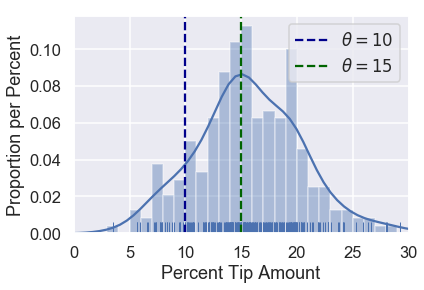

In [6]:
# HIDDEN
sns.distplot(tips['pcttip'], bins=np.arange(30), rug=True)

plt.axvline(x=10, c='darkblue', linestyle='--', label=r'$ \theta = 10$')
plt.axvline(x=15, c='darkgreen', linestyle='--', label=r'$ \theta = 15$')
plt.legend()

plt.xlim(0, 30)
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

Since $ \theta = 15 $ falls closer to most of the points, our loss function should output a small value for $ \theta = 15 $ and a larger value for $ \theta = 10 $.

Let's use this intuition to create a loss function.

## Our First Loss Function: Mean Squared Error

We would like our choice of $ \theta $ to fall close to the points in our dataset. Thus, we can define a loss function that outputs a larger value as $ \theta $ gets further away from the points in the dataset. We start with a simple loss function called the *mean squared error*. Here's the idea:

1. We select a value of $ \theta $.
2. For each value in our dataset, take the squared difference between the value and theta: $ (y_i - \theta)^2 $ . Squaring the difference in a simple way to convert negative differences into positive ones. We want to do this because if our point $ y_i = 14 $, $ \theta = 10 $ and $ \theta = 18 $ are equally far away from the point and are thus equally "bad".
3. To compute the final loss, take the average of each of the individual squared differences.

This gives us a final loss function of:

$$
\begin{aligned}
L(\theta, y_1, y_2, \ldots, y_n)
&= \text{average}\left\{ (y_1 - \theta)^2, (y_2 - \theta)^2, \ldots, (y_n - \theta)^2 \right\} \\
&= \frac{1}{n} \left((y_1 - \theta)^2 + (y_2 - \theta)^2 + \ldots + (y_n - \theta)^2 \right) \\
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

Creating a Python function to compute the loss is simple:

In [7]:
def mse_loss(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

Let's see how this loss function behaves. Suppose we have a dataset only containing one point, $ y_1 = 14 $. We can try different values of $ \theta $ and see what the loss function outputs for each value.

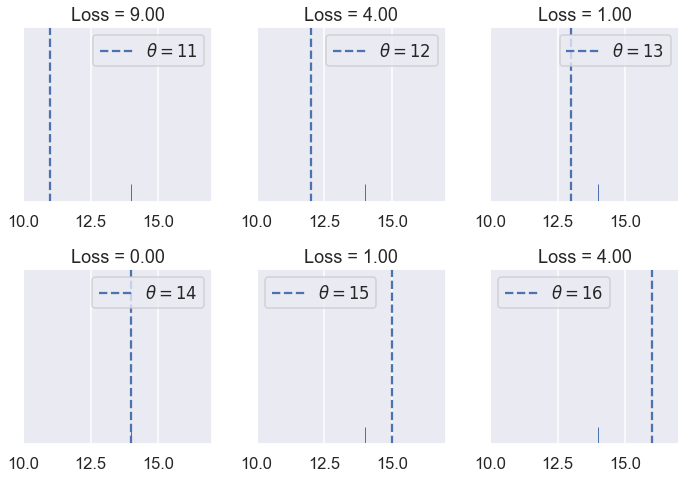

In [8]:
# HIDDEN
def try_thetas(thetas, y_vals, xlims, loss_fn=mse_loss, figsize=(10, 7), cols=3):
    if not isinstance(y_vals, np.ndarray):
        y_vals = np.array(y_vals)
    rows = int(np.ceil(len(thetas) / cols))
    plt.figure(figsize=figsize)
    for i, theta in enumerate(thetas):
        ax = plt.subplot(rows, cols, i + 1)
        sns.rugplot(y_vals, height=0.1, ax=ax)
        plt.axvline(theta, linestyle='--',
                    label=rf'$ \theta = {theta} $')
        plt.title(f'Loss = {loss_fn(theta, y_vals):.2f}')
        plt.xlim(*xlims)
        plt.yticks([])
        plt.legend()
    plt.tight_layout()

try_thetas(thetas=[11, 12, 13, 14, 15, 16],
           y_vals=[14], xlims=(10, 17))

You can also interactively try different values of $ \theta $ below. You should understand why the loss for $ \theta = 11 $ is many times higher than the loss for $ \theta = 13 $.

In [9]:
# HIDDEN
def try_thetas_interact(theta, y_vals, xlims, loss_fn=mse_loss):
    if not isinstance(y_vals, np.ndarray):
        y_vals = np.array(y_vals)
    plt.figure(figsize=(4, 3))
    sns.rugplot(y_vals, height=0.1)
    plt.axvline(theta, linestyle='--')
    plt.xlim(*xlims)
    plt.yticks([])
    print(f'Loss for theta = {theta}: {loss_fn(theta, y_vals):.2f}')

def mse_interact(theta, y_vals, xlims):
    plot = interactive(try_thetas_interact, theta=theta,
                       y_vals=fixed(y_vals), xlims=fixed(xlims),
                       loss_fn=fixed(mse_loss))
    plot.children[-1].layout.height = '240px'
    return plot
    
mse_interact(theta=(11, 16, 0.5), y_vals=[14], xlims=(10, 17))

interactive(children=(FloatSlider(value=13.0, description='theta', max=16.0, min=11.0, step=0.5), Output(layout=Layout(height='240px'))), _dom_classes=('widget-interact',))

As we hoped, our loss is larger as $ \theta $ is further away from our data and is smallest when $ \theta $ falls exactly onto our data point. Let's now see how our mean squared error behaves when we have five points instead of one. Our data this time are: $ [11, 12, 15, 17, 18 ] $.

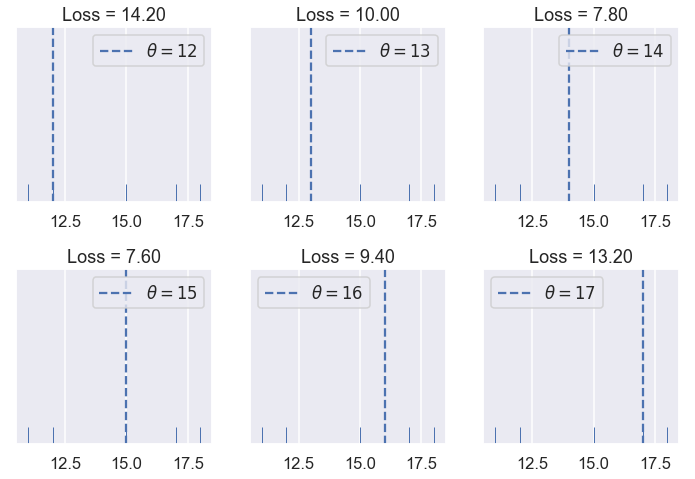

In [29]:
# HIDDEN
try_thetas(thetas=[12, 13, 14, 15, 16, 17],
           y_vals=[11, 12, 15, 17, 18],
           xlims=(10.5, 18.5))

Of the values of $ \theta $ we tried $ \theta = 15 $ has the lowest loss. However, a value of $ \theta $ in between 14 and 15 might have an even lower loss than $ \theta = 15 $. See if you can find a better value of $ \theta $ using the interactive plot below.

In [31]:
# HIDDEN
mse_interact(theta=(12, 17, 0.2),
             y_vals=[11, 12, 15, 17, 18],
             xlims=(10.5, 18.5))

interactive(children=(FloatSlider(value=14.0, description='theta', max=17.0, min=12.0, step=0.2), Output(layout=Layout(height='240px'))), _dom_classes=('widget-interact',))

The mean squared error seems to be doing its job by penalizing values of $ \theta $ that are far away from the center of the data. Let's now see what the loss function outputs on the original dataset of tip percents. For reference, the original distribution of tip percents is plotted below:

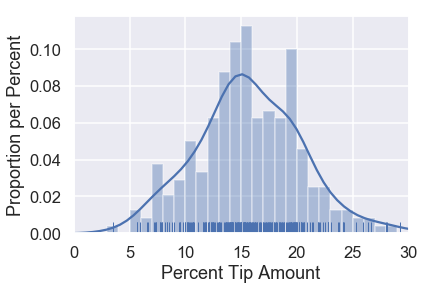

In [12]:
# HIDDEN
sns.distplot(tips['pcttip'], bins=np.arange(30), rug=True)
plt.xlim(0, 30)
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

Let's try some values of $ \theta $.

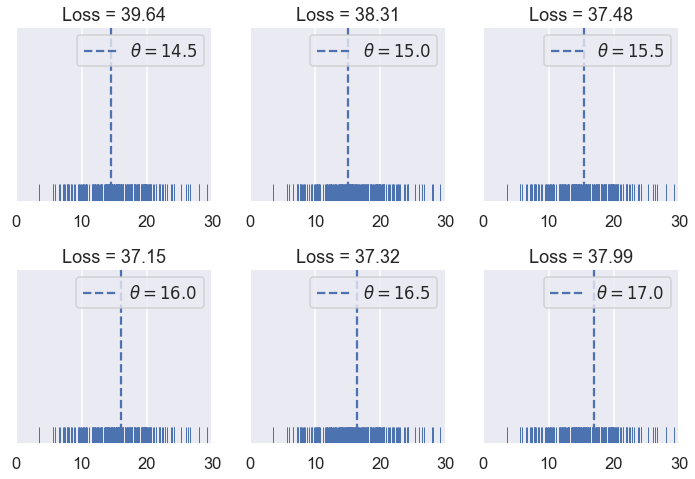

In [20]:
# HIDDEN
try_thetas(thetas=np.arange(14.5, 17.1, 0.5),
           y_vals=tips['pcttip'],
           xlims=(0, 30))

As before, we've created an interactive widget to test different values of $ \theta $.

In [14]:
# HIDDEN
mse_interact(theta=(13, 17, 0.25),
             y_vals=tips['pcttip'],
             xlims=(0, 30))

interactive(children=(FloatSlider(value=15.0, description='theta', max=17.0, min=13.0, step=0.25), Output(layout=Layout(height='240px'))), _dom_classes=('widget-interact',))

It looks like the best value of $ \theta $ that we've tried so far is 16.00, slightly above our original guess of 15% tip.

## A Shorthand

We have defined our first loss function, the mean squared error (MSE). It computes high loss for values of $ \theta $ that are further away from the center of the data. Mathematically, this loss function is defined as:

$$
\begin{aligned}
L(\theta, y_1, y_2, \ldots, y_n)
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

The loss function will compute different losses whenever we change either $ \theta $ or $ y_1, y_2, \ldots, y_n $. We've seen this happen when we tried different values of $ \theta $ and when we added new data points (changing $ y_1, y_2, \ldots, y_n $). 

As a shorthand, we can define the vector $ \textbf{y} = [ y_1, y_2, \ldots, y_n ] $. Then, we can write MSE as:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

### Minimizing the Loss

So far, we have found the best value of $ \theta $ by simply trying out a bunch of values and then picking the one with the least loss. Although this method works decently well, we can find a better method by using the properties of our loss function.

For the following example, we use a dataset containing five points: $ \textbf{y} = [ 11, 12, 15, 16, 17 ] $.

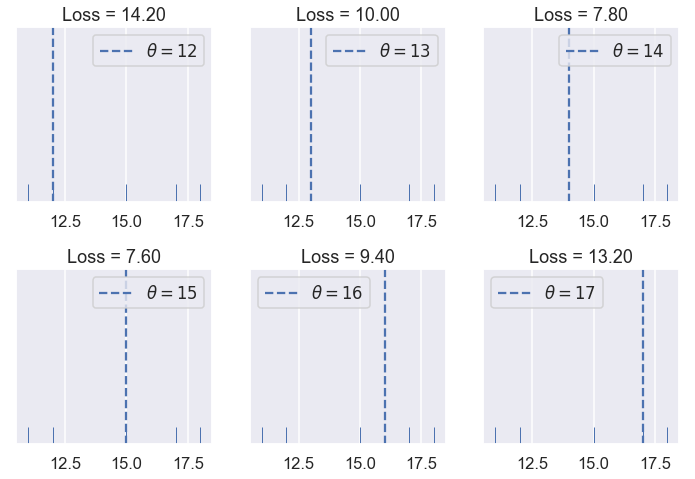

In [32]:
# HIDDEN
try_thetas(thetas=[12, 13, 14, 15, 16, 17],
           y_vals=[11, 12, 15, 17, 18],
           xlims=(10.5, 18.5))

In the plots above, we've used integer $ \theta $ values in between 12 and 17. When we change $ \theta $, the loss seems to start high (at 10.92), decrease until $ \theta = 15 $, then increase again. We can see that the loss changes as $ \theta $ changes, so let's make a plot comparing the loss to $ \theta $ for each of the six $ \theta $s we've tried.

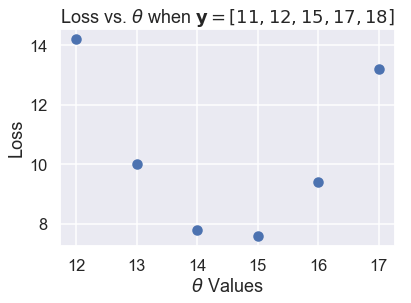

In [33]:
# HIDDEN
thetas = np.array([12, 13, 14, 15, 16, 17])
y_vals = np.array([11, 12, 15, 17, 18])
losses = [mse_loss(theta, y_vals) for theta in thetas]

plt.scatter(thetas, losses)
plt.title(r'Loss vs. $ \theta $ when $\bf{y}$$ = [11, 12, 15, 17, 18] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss');

The scatter plot shows the downward, then upward trend that we noticed before. We can try more values of $ \theta $ to see a complete curve that shows how the loss changes as $ \theta $ changes.

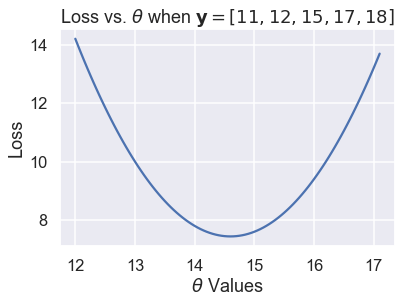

In [34]:
# HIDDEN
thetas = np.arange(12, 17.1, 0.05)
y_vals = np.array([11, 12, 15, 17, 18])
losses = [mse_loss(theta, y_vals) for theta in thetas]

plt.plot(thetas, losses)
plt.title(r'Loss vs. $ \theta $ when $\bf{y}$$ = [11, 12, 15, 17, 18] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss');

The plot above shows that in fact, $ \theta = 15$ was not the best choice; a $ \theta $ between 14 and 15 would have gotten a lower loss. We can use calculus to find that minimizing value of $ \theta $ exactly. At the minimum loss, the derivative of the loss function with respect to $ \theta $ is 0.

First, we start with our loss function:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\end{aligned}
$$

Next, we plug in our points $ \textbf{y} = [11, 12, 15, 17, 18] $:

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{5} \big((11 - \theta)^2 + (12 - \theta)^2 + (15 - \theta)^2 + (17 - \theta)^2 + (18 - \theta)^2 \big)\\
\end{aligned}
$$

To find the value of $ \theta $ that minimizes this function, we compute the derivative with respect to $ \theta $:

$$
\begin{aligned}
\frac{\partial}{\partial \theta} L(\theta, \textbf{y})
&= \frac{1}{5} \big(-2(11 - \theta) - 2(12 - \theta) - 2(15 - \theta) - 2(17 - \theta) -2(18 - \theta) \big)\\
&= \frac{1}{5} \big(10 \cdot \theta - 146 \big)\\
\end{aligned}
$$

Then, we find the value of $ \theta $ where the derivative is zero:

$$
\begin{aligned}
\frac{1}{5} \big(10 \cdot \theta - 146 \big) &= 0 \\
10 \cdot \theta - 146 &= 0 \\
\theta &= 14.6
\end{aligned}
$$

We've found the minimizing $ \theta $, and as expected, it is between 14 and 15. We denote the $ \theta $ that minimizes the loss $ \hat{\theta} $. Thus, for the dataset $ \textbf{y} = [11, 12, 15, 17, 18] $ and the MSE loss function:

$$ \hat{\theta} = 14.6 $$

If we happen to compute the mean of the data values, we notice a curious equivalence:

$$ \text{mean} (\textbf{y}) = \hat{\theta} = 14.6 $$

## The Minimizing Value of the Mean Squared Error

As it turns out, the equivalence above is no mere coincidence; the average of the data values *always* produces $ \hat{\theta} $, the $ \theta $ that minimizes the MSE loss.

To show this, we take the derivative of our loss function once more. Instead of plugging in points, we leave the $ y_i $ terms intact to generalize to other datasets.

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\frac{\partial}{\partial \theta} L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n} -2(y_i - \theta) \\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \theta) \\
\end{aligned}
$$

Since we did not substitute in specific values for $ y_i $, this equation can be used with any dataset with any number of points.

Now, we set the derivative equal to zero and solve for $ \theta $ to find the minimizing value of $ \theta $ as before:

$$
\begin{aligned}
-\frac{2}{n} \sum_{i = 1}^{n} (y_i - \theta) &= 0 \\
\sum_{i = 1}^{n} (y_i - \theta) &= 0 \\
\sum_{i = 1}^{n} y_i - \sum_{i = 1}^{n} \theta &= 0 \\
\sum_{i = 1}^{n} \theta &= \sum_{i = 1}^{n} y_i \\
n \cdot \theta &= y_1 + \ldots + y_n \\
\theta &= \frac{y_1 + \ldots + y_n}{n} \\
\hat \theta = \theta &= \text{mean} (\textbf{y})
\end{aligned}
$$

Lo and behold, we see that there is a single value of $ \theta $ that gives the least MSE no matter what the dataset is. For the mean squared error, we know that $ \hat{\theta} $ is the mean of the dataset values.

## Back to the Original Dataset

We no longer have to test out different values of $ \theta $ as we did before. We can compute the mean tip percentage in one go:

In [18]:
np.mean(tips['pcttip'])

16.080258172250463

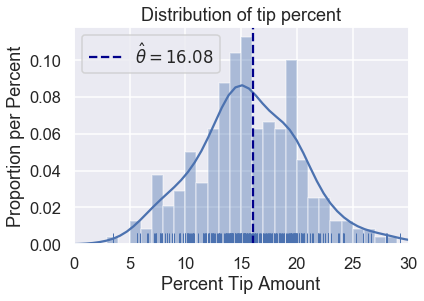

In [37]:
# HIDDEN
sns.distplot(tips['pcttip'], bins=np.arange(30), rug=True)

plt.axvline(x=16.08, c='darkblue', linestyle='--', label=r'$ \hat \theta = 16.08$')
plt.legend()

plt.xlim(0, 30)
plt.title('Distribution of tip percent')
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

## Summary

We have introduced a **constant model**, a model that outputs the same number for all entries in the dataset.

A **loss function** $ L(\theta, \textbf{y}) $ measures how well a given value of $ \theta $ fits the data. In this section, we introduce the mean squared error loss function and showed that $ \hat{\theta} = \text{mean}(\textbf{y}) $ for the constant model.

The steps we took in this section apply to many modeling scenarios:

1. Select a model.
2. Select a loss function.
3. Fit the model by minimizing the loss.

In this book, all of our modeling techniques expand upon one or more of these steps. We introduce new models (1), new loss functions (2), and new techniques for minimizing loss (3).